<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/S4/extras/MNIST%2099_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


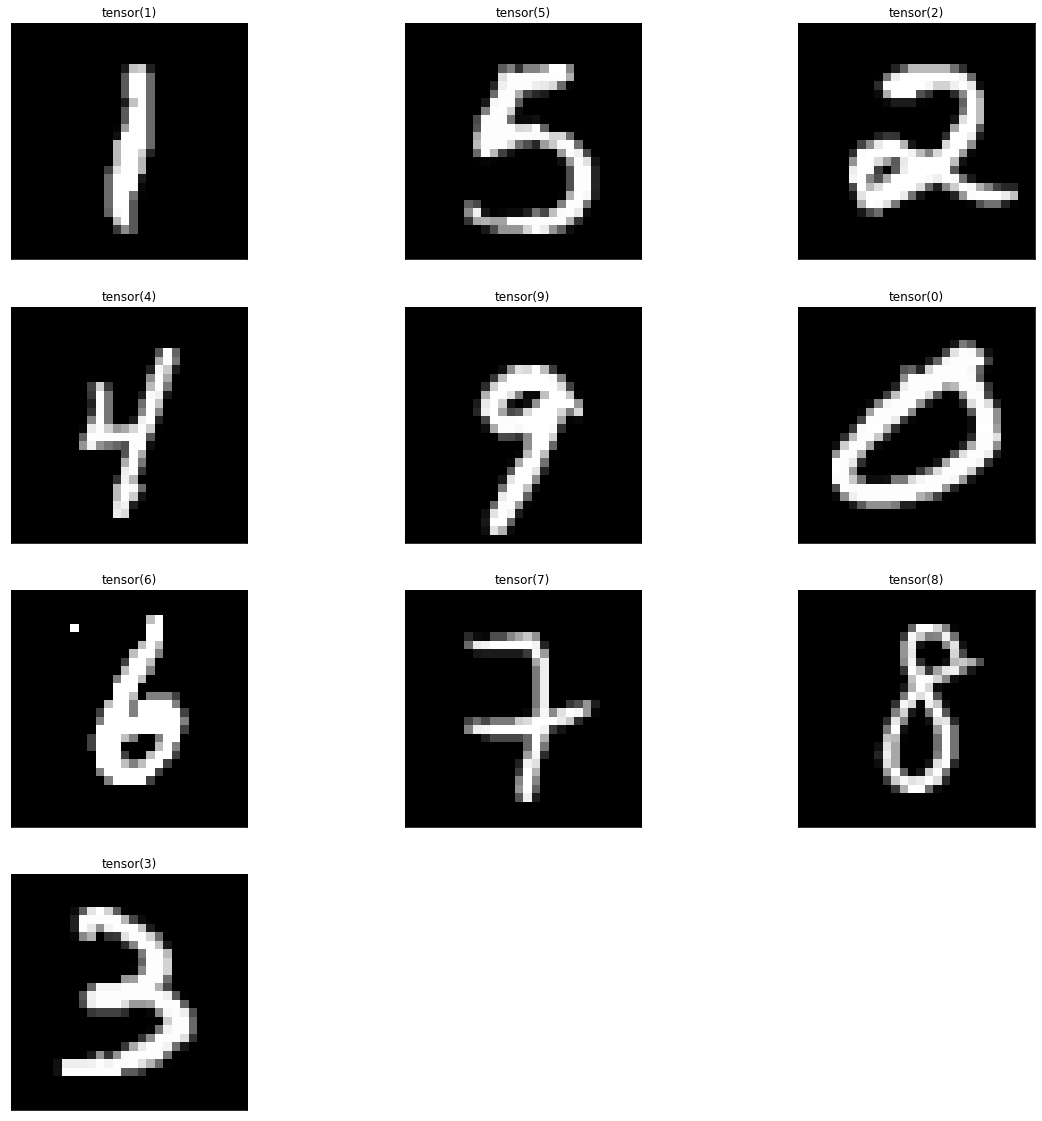

In [0]:
classes = range(10)
imgs, lbls = next(iter(train_loader))
# print(imgs[7].data.shape)
# print(imgs.data.min())
# print(imgs.data.max())
# print(imgs.data.mean())
# print(imgs.data.std())
# print(classes[lbls[0]])

nos = [0,1,2,3,4,5,6,7,8,9]
j=0
fig = plt.figure(figsize=(20,20))
for i in range(len(imgs)):
  if classes[lbls[i]] in nos:
    # plt.imshow(imgs[i].data.reshape((28,28)), cmap="gray")
    ax = fig.add_subplot(4,3 , 1 + j, xticks=[], yticks=[])
    plt.imshow(imgs[i].data.reshape((28,28)), cmap="gray")
    ax.set_title(lbls[i])
    nos.remove(classes[lbls[i]])
    j+=1

  
plt.show()



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding=0),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(16),

            nn.Conv2d( 16,10, 3, padding=0),
            
        )


    def forward(self, x):

        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
           Dropout-3           [-1, 16, 26, 26]               0
       BatchNorm2d-4           [-1, 16, 26, 26]              32
            Conv2d-5           [-1, 16, 24, 24]           2,320
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
            Conv2d-9           [-1, 16, 22, 22]           2,320
             ReLU-10           [-1, 16, 22, 22]               0
          Dropout-11           [-1, 16, 22, 22]               0
      BatchNorm2d-12           [-1, 16, 22, 22]              32
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch= {epoch} loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9823/10000 (98.2300%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9887/10000 (98.8700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9898/10000 (98.9800%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9895/10000 (98.9500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9925/10000 (99.2500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.3000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.2500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.3100%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.3600%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.3700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.3700%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.3500%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.4000%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.4400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9944/10000 (99.4400%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.3900%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.4300%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.4500%)



epoch= 19 loss=0.012116332538425922 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.4200%)

